# 1. Set up the python environment

### Install python libraries and clone the github repo

In [ ]:
!pip3 install numpy scipy matplotlib autograd==1.1.13 tick numpydoc==0.7.0
!git clone https://github.com/RuiZhang2016/Efficient-Nonparametric-Bayesian-Hawkes-Processes.git ENBHP

### Add the path of the local repo

In [ ]:
import sys
sys.path.append('./BNPHP')

### Import libraries

In [16]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from tick.base import TimeFunction
from tick.hawkes import SimuInhomogeneousPoisson
import gibbs_hawkes as gh
import wp

# 2. Implement Gibbs-Hawkes

In [2]:
def squared_normal_shape_scale(mu, sigma):
    # calculate alpha and beta in Eqn. (9)
    
    shape = (mu ** 2 + sigma ** 2) ** 2 / (2 * sigma ** 2 * (2 * mu ** 2 + sigma ** 2))
    scale = (2 * mu ** 2 * sigma ** 2 + sigma ** 4) / (mu ** 2 + sigma ** 2)
    return shape, scale


def squared_normal_quantiles(mu, sigma, probs, double=False):
    # quantiles of Y = 1/2 X^2 where X ~ N(mu, sigma^2)
    # if probs is none, return the mean
    
    assert len(mu) == len(sigma)
    factor = 2.0 if double else 1.0
    mu = mu.flatten()
    sigma = sigma.flatten()
    shape, scale = squared_normal_shape_scale(mu, sigma)
    if probs is None:
        return shape * scale * factor
    else:
        probs2 = 1 - np.array(probs).flatten()
        rval = np.array([gamma(a=thisshape, scale=thisscale).isf(probs2) for thisshape, thisscale in zip(shape, scale)])
    return rval * factor


def log_post_w(w, cov, xs, f2, phix):
    # log of the posterior distribution of w
    
    f1 = -np.sum(np.log(np.dot(phix, w)**2))
    df1 = -np.dot(phix.T, 2/np.abs(np.dot(phix, w)))
    f = np.dot(f2+cov.Lambdainv, w)
    f2 = np.dot(w, f)*0.5
    df2 = f
    return f1 + f2, df1 + df2


def laplace_map_w(cov, xs, Omega):
    # Eqn. (20) and (21), i.e.,
    # calculate the optimal w and Q
    
    phix = cov._phi(np.array(sorted(np.concatenate([x[0] for x in xs]))).reshape((1, -1)))
    f2 = np.sum(cov._integral_phiphi(np.array([np.pi - x[1] for x in xs])), axis=0)
    fn = lambda w: log_post_w(w, cov, xs, f2, phix)
    w0 = (1 + np.random.rand(cov.params.nterms))*0.01
    res = minimize(fn, w0, method=_minimize_method, jac=True, options=_minimize_options)
    what = res.x
    Omega_I = Omega + f2
    fhat = np.sum(phix * what, axis=1)
    phix_div_f = phix / np.dot(phix, what).reshape(-1, 1)
    Qinv = 2*np.dot(phix_div_f.T, phix_div_f)+Omega_I
    Qinv = 0.5*(Qinv.T + Qinv)
    L = np.linalg.cholesky(Qinv)
    Linv = np.linalg.inv(L)
    Q = Linv.T @ Linv
    return what, Q, fhat


_ml_key = r'$\log p(X|\Omega,k)$'


def laplace_pred_w(phixstar, w, Q):
    # infer the distribution of any set of x
    
    mustar = np.dot(phixstar, w)
    Sigmastar = phixstar @ Q @ phixstar.T
    sigmastar = np.sqrt(np.diag(Sigmastar))
    return mustar, sigmastar, Sigmastar


def sij(x, phi, mu):
    # calculate probabilities of branching structures (Eqn. (10) and (11)) and
    # sample a branching structure
    
    d, nx = x.shape
    sij = np.zeros(nx)
    for idx in range(1, nx):
        l = phi(x[0, idx] - x[0, :idx])
        pij = (np.append([mu],l))/(mu+np.sum(l))
        sij[idx] = np.random.choice(range(idx + 1), 1, p=pij)
    return sij

# 3. Simulate the Hawkes Process

### 3.1 Define a Hawkes process model in tick
First, we define a cosine triggering kernel 
$$\phi_{\cos}(t) = \begin{cases}\cos(3\pi t)+1 & t \in [0,1] \\ 0 & otherwise \end{cases}.$$

In [3]:
# cosine triggering kernel
run_time = np.pi
ts1 = np.linspace(0, 1, 512)
f = lambda t: np.cos(3*np.pi*t)+1
ys1 = f(ts1)
tf_phi_cos = TimeFunction([ts1, ys1])

Second, we define a background intensity $$\mu=10.$$

In [4]:
# backgroun intensity: mu = 10
ts2 = np.linspace(0, run_time, 256)
ys2 = np.ones(len(ts2))*10
tf_mu = TimeFunction([ts2, ys2])

This is how the cosine triggering kernel looks like.

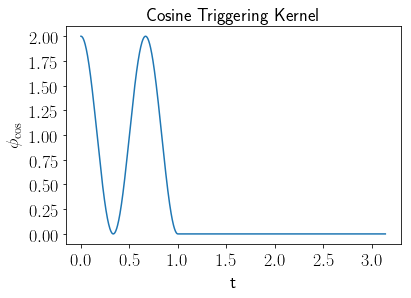

In [5]:
# visualize the triggering kernel
xplot = np.linspace(0,run_time,1024)
plt.plot(xplot, tf_phi_cos.value(xplot))
plt.xlabel('t',fontsize=18)
plt.ylabel('$\phi_{\cos}$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Cosine Triggering Kernel',fontsize=18)
plt.show()

### 3.2 Simulate the Hawkes process model
First, define the simulation function.

In [6]:
def BS_simulation_stack(phi, mu, run_time):
    # simulate a Hawkes process using the represention of 
    # the Poisson cluster processes
    
    in_poi = SimuInhomogeneousPoisson([mu], end_time=run_time, verbose=False)
    in_poi.simulate()
    p = 0
    D = [(p, t) for t in in_poi.timestamps[0]]
    while True:
        c = D[p][1]
        p = p+1
        in_poi = SimuInhomogeneousPoisson([phi], end_time=run_time - c, verbose=False)
        in_poi.simulate()
        D += [(p, t + c) for t in in_poi.timestamps[0]]
        if p == len(D):
            break
    return D

Simulate 10 point sequences.

In [7]:
num_hist = 10
hp_data_list = []
for _ in range(num_hist):
    D = BS_simulation_stack(tf_phi_cos, tf_mu, run_time)
    hp_data = np.array(sorted([d[1] for d in D]))
    hp_data_list += [hp_data]

hp_data_list = [np.array([hist]) for hist in hp_data_list]
print('The format of data is: [np.array([[ascending points]]), ..., np.array([[ascending points]])]')

The format of data is: [np.array([[ascending points]]), ..., np.array([[ascending points]])]


This is how toy data look like: 

In [8]:
print(hp_data_list)

[array([[0.01027088, 0.07136142, 0.12523653, 0.49964589, 0.53396917,
        0.60306619, 0.67258341, 0.77761956, 0.7956494 , 0.82397688,
        0.88421691, 0.9067148 , 0.96321615, 0.96381295, 1.1629275 ,
        1.18048983, 1.18905616, 1.25962688, 1.26237001, 1.34340305,
        1.34963742, 1.43489084, 1.46635859, 1.49877463, 1.51056604,
        1.52427178, 1.5417495 , 1.57865394, 1.60096892, 1.60241801,
        1.6536389 , 1.8423244 , 1.84629466, 1.90005104, 1.9167201 ,
        1.93725079, 1.93768621, 1.93799445, 1.98810146, 1.99630074,
        2.02480248, 2.02532792, 2.06817528, 2.10569113, 2.14506043,
        2.14865243, 2.14871036, 2.19425022, 2.2201404 , 2.23051876,
        2.24189201, 2.26043252, 2.27062341, 2.28166345, 2.3646818 ,
        2.36695729, 2.37546972, 2.37913353, 2.38733217, 2.41355992,
        2.43323225, 2.4722421 , 2.47597819, 2.48858851, 2.49618185,
        2.50730519, 2.55020915, 2.57426621, 2.59193237, 2.63507692,
        2.63521136, 2.64094311, 2.64692444, 2.6

# 4. Experiment - Infer the True Triggering Kernel
### The infer() function is long but you can use it in a simple way: infer(your_data, plotted_x)

In [10]:
xplot = np.linspace(0., 2, 128).reshape((1, -1))
rm_f, rstd_f, rm_mu, rstd_mu = gh.infer(hp_data_list, xplot)

plot the posterior distribution of the triggering kernel

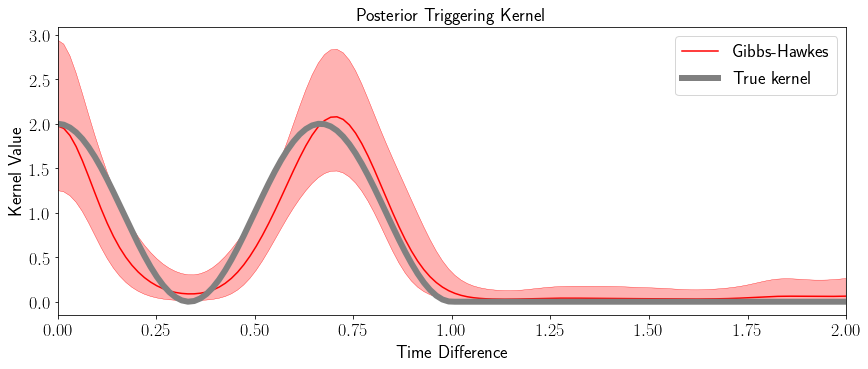

In [18]:
# ploting the estimated posterior distribution

# plot configuration
def plt_config(tf_phi):
    if tf_phi:
        plt.plot(xplot.flatten(), [tf_phi.value(x) for x in xplot.flatten()], 'gray', lw=6, label="True kernel")
    plt.xlabel('Time Difference', fontsize=18)
    plt.ylabel('Kernel Value', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

plt.figure(figsize = (12,5))
quantiles = gh.squared_normal_quantiles(rm_f.aggregate().flatten(), rstd_f.aggregate().flatten(), [0.1, 0.5, 0.9])
wp.gpplot(xplot[0], quantiles[:, 1], quantiles[:, 0], quantiles[:, 2], fillcol='r', edgecol='r',mulabel='Gibbs-Hawkes')
plt_config(tf_phi_cos)
plt.tight_layout()
plt.xlim(0,2)
plt.legend(loc='best',prop={'size':18})
plt.title('Posterior Triggering Kernel',fontsize=18)
plt.show()